In [1]:
! pip install -U pandas

    100% |################################| 10.1MB 97kB/s  eta 0:00:01
    100% |################################| 512kB 1.5MB/s eta 0:00:01
    100% |################################| 17.0MB 59kB/s  eta 0:00:01
    100% |################################| 235kB 5.3MB/s eta 0:00:01
  Found existing installation: pytz 2017.2
    Uninstalling pytz-2017.2:
      Successfully uninstalled pytz-2017.2
  Found existing installation: numpy 1.13.1
    Uninstalling numpy-1.13.1:
      Successfully uninstalled numpy-1.13.1
  Found existing installation: six 1.10.0
    Uninstalling six-1.10.0:
      Successfully uninstalled six-1.10.0
  Found existing installation: python-dateutil 2.6.1
    Uninstalling python-dateutil-2.6.1:
      Successfully uninstalled python-dateutil-2.6.1
  Found existing installation: pandas 0.20.3
    Uninstalling pandas-0.20.3:
      Successfully uninstalled pandas-0.20.3
You are using pip version 9.0.1, however version 21.1 is available.
You should consider upgrading via 

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from ripser import Rips
import seaborn as sns
import numpy as np

In [4]:
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Load Data

In [5]:
embeds = np.load('/notebooks/subgraphs/graph_embeds.npy')
embeds_tda = np.load('/notebooks/subgraphs/graph_embeds_tda.npy')
labels = np.load('/notebooks/subgraphs/graph_labels.npy')

In [6]:
feat_cols = ['feat-{}'.format(i) for i in range(embeds.shape[1])]
feat_tda_cols = ['feat-{}'.format(i) for i in range(embeds_tda.shape[1])]
class_cols = ['class-{}'.format(i) for i in range(labels.shape[1])]

In [7]:
train_embed = pd.DataFrame(embeds, columns=feat_cols)
train_embed_tda = pd.DataFrame(embeds_tda, columns=feat_tda_cols)
train_label = pd.DataFrame(labels, columns=class_cols)

# PCA

In [8]:
def do_pca(train_embed, n_comp=3):
    pca = PCA(n_components=n_comp)
    pca_result = pca.fit_transform(train_embed[feat_cols].values)
    train_embed['pca-one'] = pca_result[:,0]
    if n_comp > 1:
        train_embed['pca-two'] = pca_result[:,1]
    if n_comp > 2:
        train_embed['pca-three'] = pca_result[:,2]
        
    print 'Explained variation per principal component: {}'.format(pca.explained_variance_ratio_)
    
    # For reproducability of the results
    np.random.seed(42)
    rndperm = np.random.permutation(train_embed.shape[0])
    
    # Encode Labels
    labels = [train_label.iloc[i,:].to_string(header=False, index=False) for i in range(len(train_label))]
    labels_set = set(labels)
    print 'Number of Unique Labels: {}'.format(len(labels_set))
    label2int = dict([(y,x+1) for x,y in enumerate(labels_set)])
    train_embed['y'] = pd.Series([label2int[x] for x in labels])
    
    return train_embed, rndperm

In [9]:
train_embed, rndperm_no_tda = do_pca(train_embed)

Explained variation per principal component: [0.06881136 0.05989881 0.05634615]
Number of Unique Labels: 4000


In [10]:
train_embed_tda, rndperm_tda = do_pca(train_embed_tda)

Explained variation per principal component: [0.06881138 0.05989892 0.05634666]
Number of Unique Labels: 4000


## 2D Projection

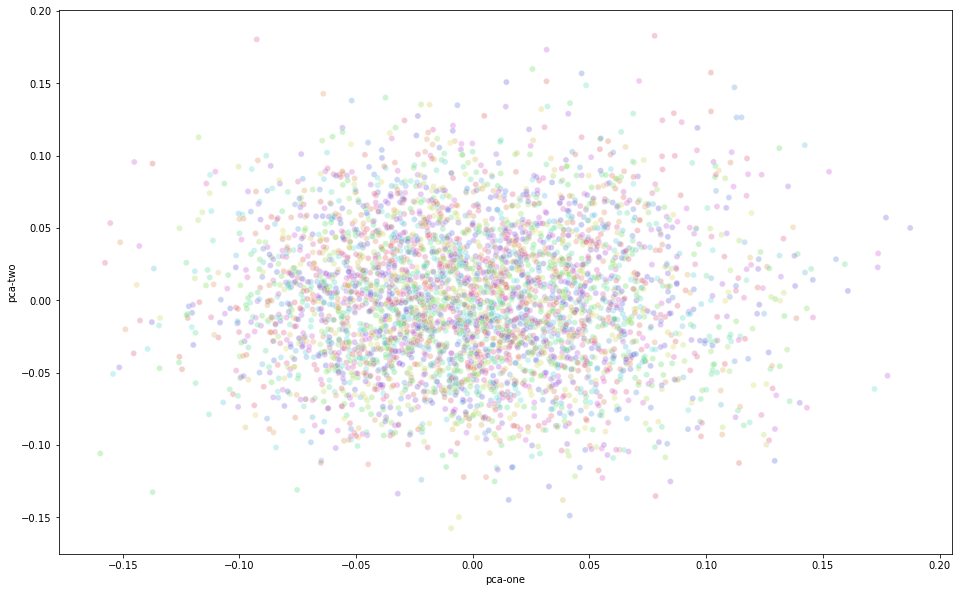

In [11]:
n_color = len(train_embed.loc[rndperm_no_tda]['y'].unique())
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", n_color),
    data=train_embed.loc[rndperm_no_tda,:],
    legend=False,
    alpha=0.3
)
plt.savefig("2D_no_tda.pdf", bbox_inches='tight')

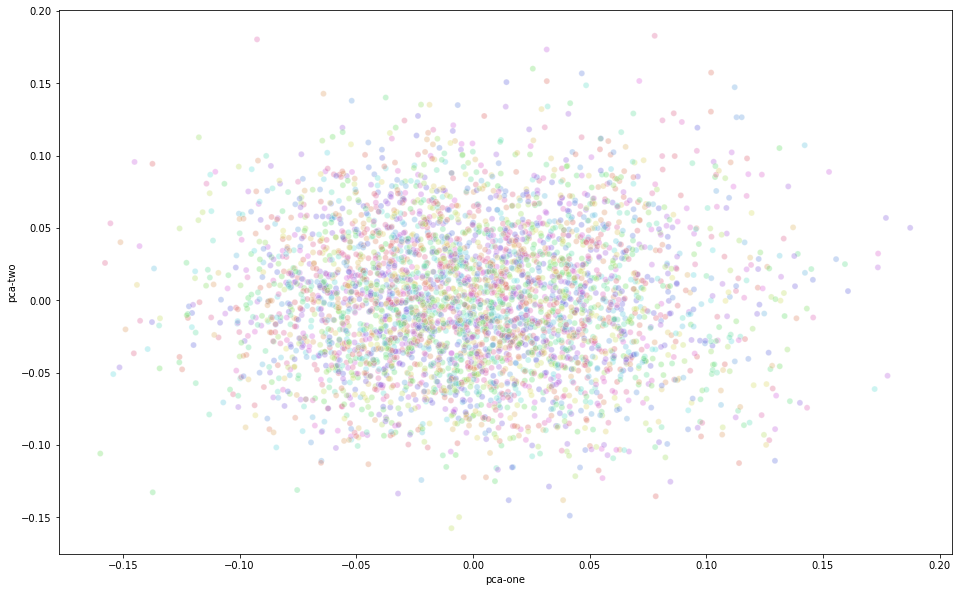

In [12]:
n_color = len(train_embed_tda.loc[rndperm_tda]['y'].unique())
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", n_color),
    data=train_embed_tda.loc[rndperm_tda,:],
    legend=False,
    alpha=0.3
)
plt.savefig("2D_tda.pdf", bbox_inches='tight')

## 3D Projection

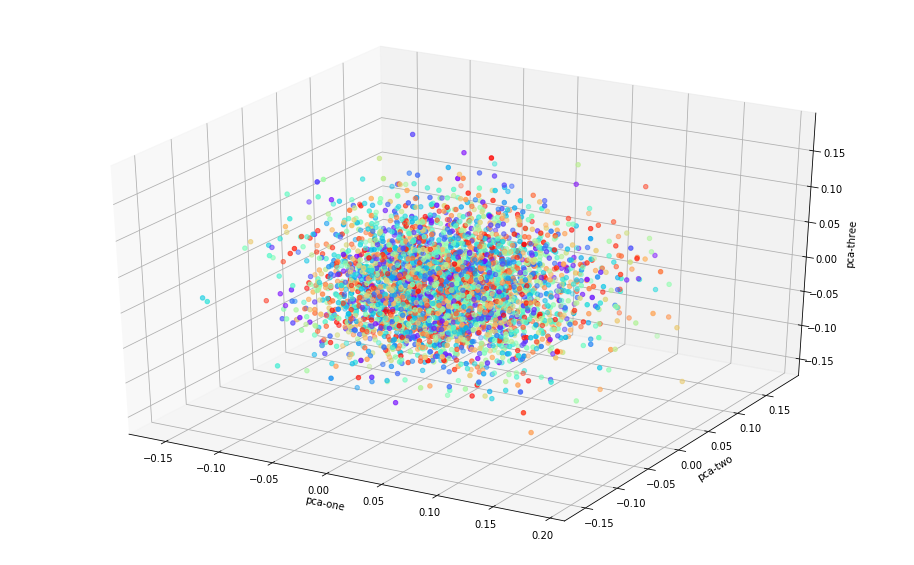

In [13]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=train_embed.loc[rndperm_no_tda,:]["pca-one"], 
    ys=train_embed.loc[rndperm_no_tda,:]["pca-two"], 
    zs=train_embed.loc[rndperm_no_tda,:]["pca-three"], 
    c=train_embed.loc[rndperm_no_tda,:]["y"],
    cmap='rainbow'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.savefig("3D_no_tda.pdf", bbox_inches='tight')
plt.show()

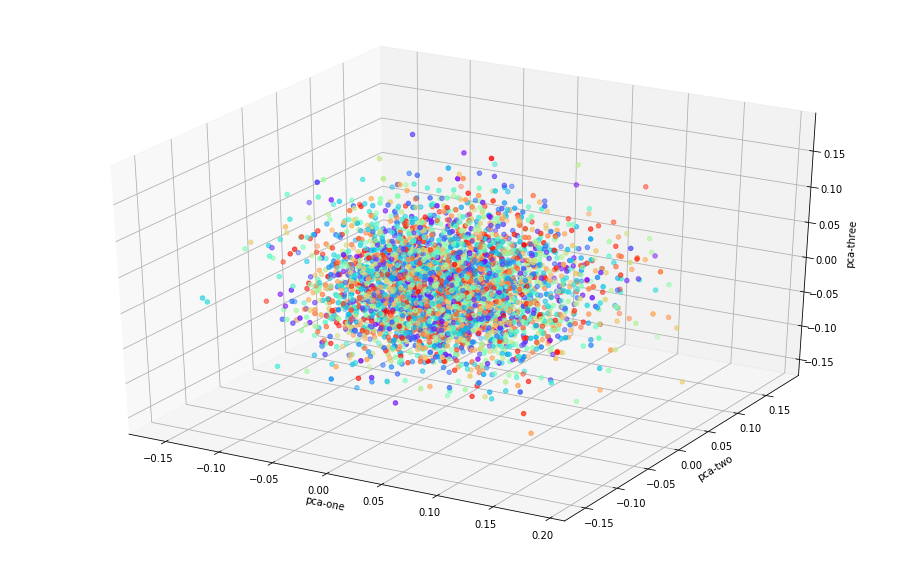

In [14]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=train_embed_tda.loc[rndperm_tda,:]["pca-one"], 
    ys=train_embed_tda.loc[rndperm_tda,:]["pca-two"], 
    zs=train_embed_tda.loc[rndperm_tda,:]["pca-three"], 
    c=train_embed_tda.loc[rndperm_tda,:]["y"],
    cmap='rainbow'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.savefig("3D_tda.pdf", bbox_inches='tight')
plt.show()

# Ripser

## Persistence Diagram

In [15]:
# train_embed.shape

In [16]:
# rips = Rips(maxdim=2)
# rips = Rips()

In [17]:
# diagrams = rips.fit_transform(train_embed.drop(columns=['pca-one', 'pca-two', 'pca-three', 'y']))

In [18]:
# rips.plot(diagrams)

## Persistence Transform

In [19]:
# lifetime_dim0_pts = diagrams[0][:, 1] - diagrams[0][:, 0] 
# lifetime_dim1_pts = diagrams[1][:, 1] - diagrams[1][:, 0] 
# lifetime_dim2_pts = diagrams[2][:, 1] - diagrams[2][:, 0]

In [20]:
# plt.scatter(diagrams[0][:, 0], lifetime_dim0_pts)
# plt.title('Dimension 0')
# plt.xlabel('Birth Time')
# plt.ylabel('Lifetime')
# plt.show()

In [21]:
# plt.scatter(diagrams[1][:, 0], lifetime_dim1_pts)
# plt.title('Dimension 1')
# plt.xlabel('Birth Time')
# plt.ylabel('Lifetime')
# plt.show()

In [22]:
# plt.scatter(diagrams[2][:, 0], lifetime_dim2_pts)
# plt.title('Dimension 2')
# plt.xlabel('Birth Time')
# plt.ylabel('Lifetime')
# plt.show()

In [23]:
# rips.plot(diagrams, lifetime=True)

In [24]:
# train_embed['birth_dim0'] = pd.Series(data=diagrams[0][:, 0])
# train_embed['lifetime_dim0'] = pd.Series(data=lifetime_dim0_pts)

In [25]:
# train_embed['birth_dim1'] = pd.Series(data=diagrams[1][:, 0])
# train_embed['lifetime_dim1'] = pd.Series(data=lifetime_dim1_pts)

In [26]:
# train_embed['birth_dim2'] = pd.Series(data=diagrams[2][:, 0])
# train_embed['lifetime_dim2'] = pd.Series(data=lifetime_dim2_pts)

In [27]:
# train_embed.columns

In [28]:
# Is concatenating like this okay?
# print(train_embed['lifetime_dim1'].shape)
# print(train_embed['lifetime_dim0'].shape)